In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as sklearn_LR
%matplotlib inline

#### 1.В этом задании вы должны модифицировать реализацию рассчёта среднеквадратичной ошибки и рассчёта её производной, так, чтобы с к среднеквадратичной ошибке добавлялась l2 регулярязационная поправка: $ +c*\sum \limits _{j}  w_{j}^2 $ а к градиенту- ссответствующее выражение для градиента регулярязационной поправки.

In [46]:
class linear_regression:
    def __init__(self, eta = 0.3, max_iter = 100, min_weight_dist = 1e-8, c = 0.001):
        self.eta = eta
        self.max_iter = max_iter
        self.min_weight_dist = min_weight_dist
        self.c = c
    def _mserror(self, X, y_real):
        #рассчёт среднеквадратичной ошибки
        y = X.dot(self.w.T)+self.w0 
        return np.sum((y - y_real)**2) / y_real.shape[0] + self.c*np.sum(self.w**2)
    def _mserror_grad(self, X, y_real):
        #рассчёт градиента ошибки.
        #2*delta.T.dot(X)/y_real.shape[0] - градиент по коэффициентам при факторах
        #np.sum(2*delta)/y_real.shape[0] - производная(градиент) при нулевом коэффициенте
        delta=(X.dot(self.w.T)+self.w0-y_real)
        return 2*delta.T.dot(X)/y_real.shape[0] + 2* self.c*self.w, np.sum(2*delta)/y_real.shape[0] 
    def _optimize(self, X, Y):
        #оптимизация коэффициентов
        iter_num = 0
        weight_dist = np.inf
        self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        while weight_dist > self.min_weight_dist and iter_num < self.max_iter:
            gr_w, gr_w0=self._mserror_grad(X, Y)
            if iter_num==0:
                #Чтобы eta адаптировалась к порядку градиента, делим на l2 норму градиента в нуле
                eta=self.eta/np.sqrt(np.linalg.norm(gr_w)**2+(gr_w0)**2)
            new_w = self.w - eta * gr_w
            new_w0= self.w0 - eta * gr_w0
            #print(f'current error: {self._mserror(X, Y)}')
            weight_dist = np.sqrt(np.linalg.norm(new_w - self.w)**2+(new_w0 - self.w0)**2)
            iter_num += 1
            self.w = new_w
            self.w0 = new_w0
    def fit(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        self._optimize(X, Y)
    def predict(self, X):
        return (X.dot(self.w.T)+self.w0).flatten()
    def test(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        return self._mserror(X, Y)

In [36]:
X = np.random.uniform(-10, 10, (100, 2))
w_true = np.random.normal(size=(1, 2 ))
Y = X.dot(w_true.T) + np.random.normal(0, 0.5, size=(100, 1))

In [37]:
lr=linear_regression(c = 0.001)
lr.fit(X, Y)
lr.test(X, Y)

0.18181310550757027

#### 2.На основе этих функций создайте свою регуляризированную полиномиальную регрессию и опробуйте на одном из примеров построения полиномиальной модели из этого урока.

In [47]:
class polynomial_regression(linear_regression):
    def __init__(self, max_power, *args, **kwargs):
        self.max_power=max_power
        super().__init__(*args, **kwargs)
    @staticmethod
    def generate_features(x, max_power):
        x=x[:, np.newaxis]
        return np.concatenate([x**i for i in range(1, max_power+1)], axis=1)
    def fit(self, x, y):
        super().fit(self.generate_features(x, self.max_power), y)
    def predict(self, x):
        return super().predict(self.generate_features(x, self.max_power)).flatten()
    def test(self, x, y):
        return super().test(self.generate_features(x, self.max_power), y)

In [48]:
# в 1м задании уже переделала родительский класс, но всё-таки здесь переопределила то же самое
class polynomial_regression_reg(polynomial_regression):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
 
    def _mserror(self, X, y_real):
        y = X.dot(self.w.T)+self.w0
        return np.sum((y - y_real)**2) / y_real.shape[0] + self.c*np.sum(self.w**2)

    def _mserror_grad(self, X, y_real): 
        delta=(X.dot(self.w.T)+self.w0-y_real)
        return 2*delta.T.dot(X)/y_real.shape[0] + 2* self.c*self.w, np.sum(2*delta)/y_real.shape[0]

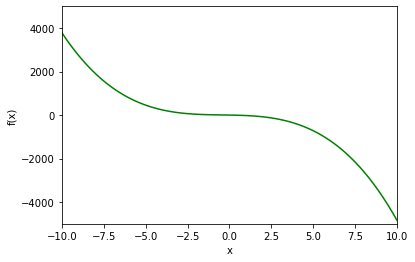

In [14]:
def f(x):
    return 0.6 - 13.2 * x - 5.3 * x ** 2 - 4.17 * x ** 3
dots = np.linspace(-10, 10, 100)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)

plt.plot(dots, f(dots), color='g')

In [15]:
np.random.seed(16)
x_data = np.random.uniform(-10, 10, 10)
f_data = [f(i) for i in x_data] + np.random.uniform(-1000, 1000, 10)

In [16]:
f_data

array([  745.4884675 ,  -851.08250932,   422.69810766,  2129.66866668,
        -413.07267878,   206.52054624,    44.24369404,  1046.66448866,
        1799.10906399, -3495.863552  ])

In [55]:
our_mod=polynomial_regression_reg(6, 0.0005, max_iter = 1e5, c = 100)
our_mod.fit(x_data, f_data)
print('Коэффициенты при факторах(наша модель):', our_mod.w)
our_mod.test(x_data, f_data)

Коэффициенты при факторах(наша модель): [[-0.00026017  0.00221116 -0.00941757  0.06163665 -0.05145382 -0.00241746]]


153502.466748139

In [50]:
our_mod.predict(x_data)

array([ 2.23046172e+02, -8.84853466e-04, -5.00894705e-02,  2.25483771e+03,
        8.23974164e+00,  2.23851423e+02, -4.24980261e+01,  5.59811843e+02,
        1.74628639e+03, -3.47347887e+03])

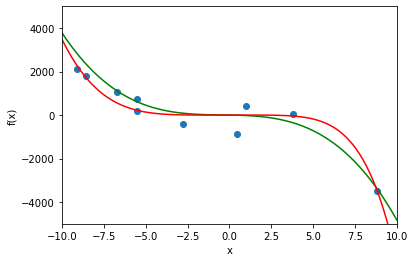

In [51]:
#Актуальные данные
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

#Наша модель
plt.plot(dots, our_mod.predict(dots), color='r')

In [52]:
def r_square(y, y_real):
    ss_total=np.sum((y_real-np.mean(y_real))**2)
    ss_res=np.sum((y_real-y)**2)
    return 1-ss_res/ss_total
print(r_square(our_mod.predict(x_data), f_data))

0.9281057304553232


In [58]:
indexes=np.arange(len(f_data))%5
y_actual=[]
y_predicted=[]

for i in range(5):
    y_actual.append(f_data[indexes==i])
    mod=polynomial_regression_reg(3, 0.0005, max_iter = 1e5, c = 0.1)
    mod.fit(x_data[indexes!=i], f_data[indexes!=i])
    y_predicted.append(mod.predict(x_data[indexes==i]))
    
y_actual=np.concatenate(y_actual)
y_predicted=np.concatenate(y_predicted)
print(r_square(y_predicted, y_actual))

0.7208868147808909


In [61]:
indexes=np.arange(len(f_data))%5
y_actual=[]
y_predicted=[]

for i in range(5):
    y_actual.append(f_data[indexes==i])
    mod=polynomial_regression_reg(6, 0.0005, max_iter = 1e5, c = 1e7)
    mod.fit(x_data[indexes!=i], f_data[indexes!=i])
    y_predicted.append(mod.predict(x_data[indexes==i]))
    
y_actual=np.concatenate(y_actual)
y_predicted=np.concatenate(y_predicted)
print(r_square(y_predicted, y_actual))

0.5477347046362833
